✅ Parsed 8 input vectors (latest batch only).
✅ Parsed 8 outputs (latest batch only).

=== Function 1 (2D) ===
  Data size: 18, Output range: [-0.0036, 64.0000]


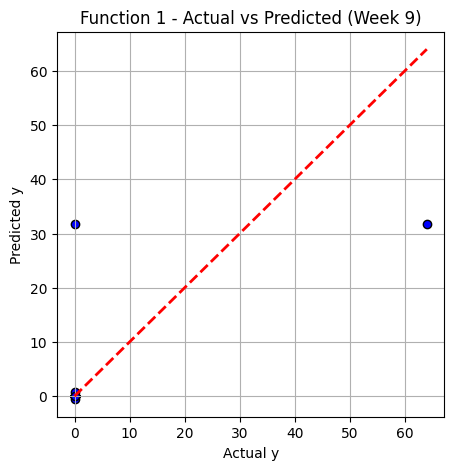

  Best predicted output: 33.3858
  Query to submit: 0.145320-0.553989

=== Function 2 (2D) ===
  Data size: 18, Output range: [-0.0656, 3.1124]


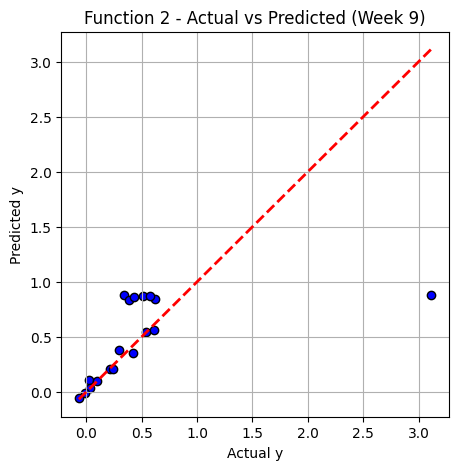

  Best predicted output: 0.8763
  Query to submit: 0.740036-0.720019

=== Function 3 (3D) ===
  Data size: 23, Output range: [-0.3989, 71.0000]


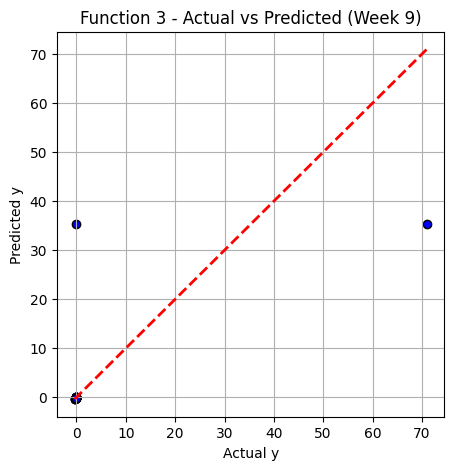

  Best predicted output: 49.5039
  Query to submit: 0.263790-0.599053-0.725163

=== Function 4 (4D) ===
  Data size: 38, Output range: [-32.6257, 64.0000]


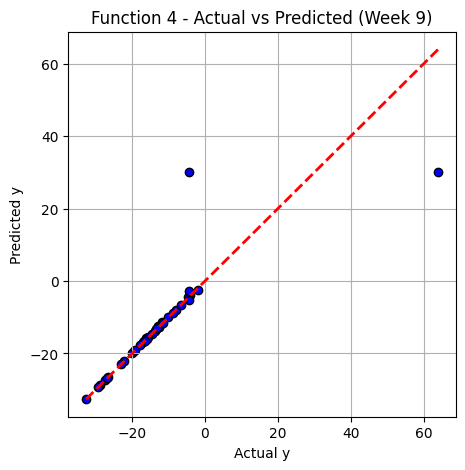

  Best predicted output: 38.1129
  Query to submit: 0.202273-0.327758-0.268333-0.337956

=== Function 5 (4D) ===
  Data size: 28, Output range: [0.1129, 4440.5225]


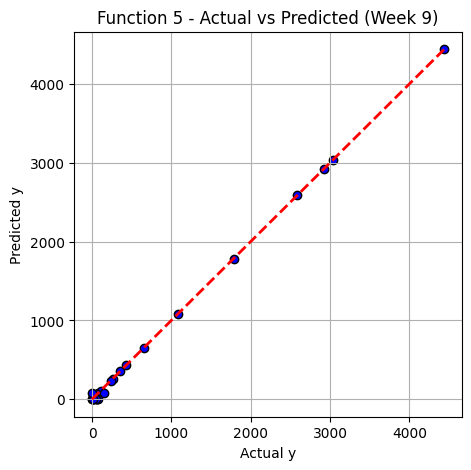

  Best predicted output: 4438.0730
  Query to submit: 0.000640-1.000000-1.000000-1.000000

=== Function 6 (5D) ===
  Data size: 28, Output range: [-2.5712, 64.0000]


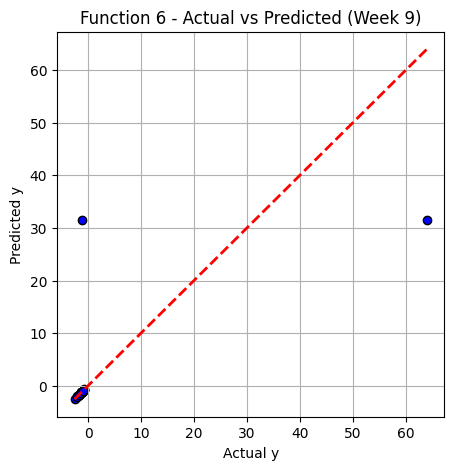

  Best predicted output: 32.4443
  Query to submit: 0.511935-0.195014-0.000000-0.691104-0.237572

=== Function 7 (6D) ===
  Data size: 38, Output range: [-0.0787, 2.0091]


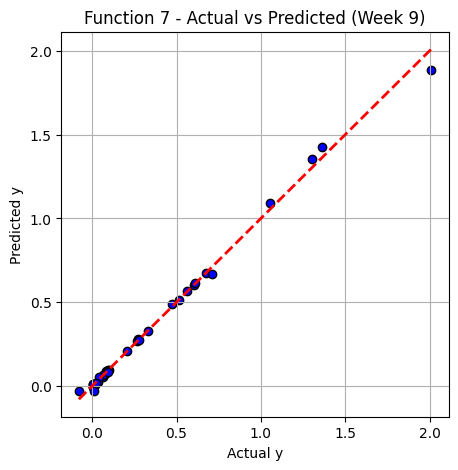

  Best predicted output: 1.9487
  Query to submit: 0.000000-0.316075-0.209477-0.232571-0.419160-0.749388

=== Function 8 (8D) ===
  Data size: 48, Output range: [5.5922, 64.0000]


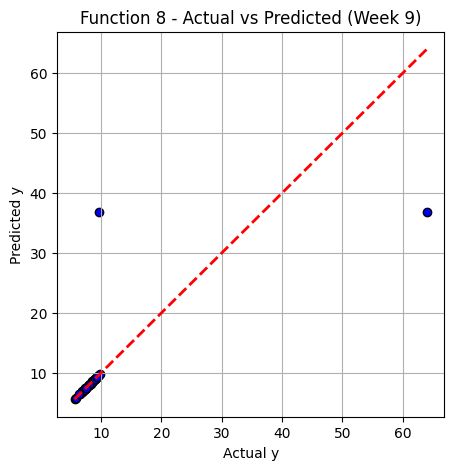

  Best predicted output: 44.5392
  Query to submit: 0.000000-0.170052-0.333259-0.490338-0.427435-0.668117-0.297541-1.000000

💾 Saved all week9 queries to week9_queries.txt

✅ DONE — Week 9 (Scaling & Emergent Behaviour) complete.


In [1]:
import numpy as np
import os
import re
import ast
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# =========================
# CONFIGURATION
# =========================
base_path = "data/"
inputs_txt = "week8/inputs.txt"       # dari email minggu sebelumnya
outputs_txt = "week8/outputs.txt"
n_candidates = 6000
save_queries = True

# =========================
# LOAD INPUTS (ambil batch terakhir)
# =========================
def load_inputs(path):
    with open(path, "r") as f:
        text = f.read().strip()
    batches = re.split(r"\]\s*\n\s*\[", text)
    last_batch = "[" + batches[-1].strip().lstrip("[").rstrip("]") + "]"
    last_batch = re.sub(r'array\(', '', last_batch).replace(')', '')
    chunks = re.findall(r'\[([^\[\]]+)\]', last_batch)
    vectors = []
    for ch in chunks:
        nums = [float(x) for x in ch.split(",") if x.strip()]
        vectors.append(np.array(nums))
    print(f"✅ Parsed {len(vectors)} input vectors (latest batch only).")
    return vectors

# =========================
# LOAD OUTPUTS
# =========================
def load_outputs(path):
    with open(path, "r") as f:
        text = f.read().strip()
    batches = re.split(r"\]\s*\n\s*\[", text)
    last_batch = batches[-1].strip()
    last_batch = last_batch.replace("np.float64(", "").replace(")", "")
    last_batch = last_batch.replace("[", "").replace("]", "")
    last_batch = re.sub(r"[^\deE\-\.\,\s]", "", last_batch)
    numbers = re.findall(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", last_batch)
    outputs = np.array([float(x) for x in numbers], dtype=float)
    print(f"✅ Parsed {len(outputs)} outputs (latest batch only).")
    return outputs

# =========================
# LOAD DATA FROM EMAIL
# =========================
new_inputs = load_inputs(inputs_txt)
new_outputs = load_outputs(outputs_txt)

# =========================
# MODEL TRAINING (WEEK 9 - Scaling & Emergent Behaviour)
# =========================
queries_out = []
for i in range(1, 9):
    folder = os.path.join(base_path, f"function_{i}")
    input_file = os.path.join(folder, "week8_inputs.npy")
    output_file = os.path.join(folder, "week8_outputs.npy")

    # Gabungkan data lama + batch baru
    X_prev = np.load(input_file)
    y_prev = np.load(output_file)
    X_combined = np.vstack([X_prev, new_inputs[i-1].reshape(1, -1)])
    y_combined = np.append(y_prev, new_outputs[i-1])

    np.save(os.path.join(folder, "week9_inputs.npy"), X_combined)
    np.save(os.path.join(folder, "week9_outputs.npy"), y_combined)

    dim = X_combined.shape[1]
    print(f"\n=== Function {i} ({dim}D) ===")
    print(f"  Data size: {len(X_combined)}, Output range: [{y_combined.min():.4f}, {y_combined.max():.4f}]")

    # =========================
    # "Scaling-inspired" surrogate:
    # Model size grows with data — mimicking scaling laws
    # =========================
    layer_size = min(512, 64 + len(X_combined) * 4)
    model = make_pipeline(
        StandardScaler(),
        MLPRegressor(
            hidden_layer_sizes=(layer_size, layer_size // 2, layer_size // 4),
            activation='relu',
            solver='adam',
            alpha=3e-4,
            learning_rate_init=0.001,
            max_iter=5000,
            random_state=42
        )
    )

    model.fit(X_combined, y_combined)
    y_pred = model.predict(X_combined)

    # Visualisasi scaling behaviour
    plt.figure(figsize=(5, 5))
    plt.scatter(y_combined, y_pred, c='blue', edgecolor='k')
    plt.plot([y_combined.min(), y_combined.max()],
             [y_combined.min(), y_combined.max()],
             'r--', lw=2)
    plt.title(f'Function {i} - Actual vs Predicted (Week 9)')
    plt.xlabel('Actual y')
    plt.ylabel('Predicted y')
    plt.grid(True)
    plt.show()

    # =========================
    # Candidate generation (scaling-aware)
    # Add slight dropout-like noise to simulate instability at scale
    # =========================
    base_context = X_combined[np.argmax(y_combined)]
    noise = np.random.normal(0, 0.08, size=(n_candidates, dim))
    candidates = np.clip(base_context + noise, 0, 1)

    preds = model.predict(candidates)
    best_idx = np.argmax(preds)
    best_query = np.clip(candidates[best_idx], 0.0, 1.0)
    query_str = "-".join([f"{x:.6f}" for x in best_query])

    print(f"  Best predicted output: {preds[best_idx]:.4f}")
    print(f"  Query to submit: {query_str}")
    queries_out.append(f"Function {i}: {query_str}")

# =========================
# SAVE WEEK9 QUERIES
# =========================
if save_queries:
    with open("week9_queries.txt", "w") as f:
        f.write("\n".join(queries_out))
    print("\n💾 Saved all week9 queries to week9_queries.txt")

print("\n✅ DONE — Week 9 (Scaling & Emergent Behaviour) complete.")